## Generate large frames for testing

In [1]:
import nbloader
from Frame2D_v03 import *

In [2]:
## NOTE: all units are kN and m

FD = {'storey_heights': [6.5] + [5.5]*20 + [7.0],                        # m
      'bay_widths': [10.5,10,10,10,10,10.5],                                  # m
      'frame_spacing':8,                                                      # m
      'specified_loads':{'live':2.4,'dead':4.0,'snow':2.5,'wind':2.5},  # kPa
      'braced_bays':[0,3],
      'support_fixity': ['fx,fy,mz']*3 + ['fx,fy']*2 + ['fx,fy,mz']*2,
      'beam_size': 'W1000x222',
      'column_size': 'W360x216',
      'load_combination': '1.25*D + 1.4*W + 0.5*L',
      }

In [3]:
FD

{'bay_widths': [10.5, 10, 10, 10, 10, 10.5],
 'beam_size': 'W1000x222',
 'braced_bays': [0, 3],
 'column_size': 'W360x216',
 'frame_spacing': 8,
 'load_combination': '1.25*D + 1.4*W + 0.5*L',
 'specified_loads': {'dead': 4.0, 'live': 2.4, 'snow': 2.5, 'wind': 2.5},
 'storey_heights': [6.5,
  5.5,
  5.5,
  5.5,
  5.5,
  5.5,
  5.5,
  5.5,
  5.5,
  5.5,
  5.5,
  5.5,
  5.5,
  5.5,
  5.5,
  5.5,
  5.5,
  5.5,
  5.5,
  5.5,
  5.5,
  7.0],
 'support_fixity': ['fx,fy,mz',
  'fx,fy,mz',
  'fx,fy,mz',
  'fx,fy',
  'fx,fy',
  'fx,fy,mz',
  'fx,fy,mz']}

In [4]:
def genframe(fd):
    h = fd['storey_heights']
    w = fd['bay_widths']
    s = fd['frame_spacing']
    nnodes = (len(h)+1)*(len(w)+1)
    
    # names of column stacks and floor levels
    bayline = [chr(ord('A')+i) for i in range(len(w)+1)]
    floorlev = [str(i) for i in range(len(h)+1)]
    
    # generate the nodes
    nodelist = []
    nidgrid = np.ndarray((len(h)+1,len(w)+1),dtype=np.object)
    for i in range(len(h)+1):
        y = sum(h[:i])*1000.
        for j in range(len(w)+1):
            x = sum(w[:j])*1000.
            nid = bayline[j]+floorlev[i]
            nodelist.append((nid,x,y))
            nidgrid[i,j] = nid
    nodes = pd.DataFrame(nodelist,columns=['ID','X','Y'])
    
    # generate the supports
    assert len(fd['support_fixity'])==nidgrid.shape[1]
    supplist = []
    for j,s in enumerate(fd['support_fixity']):
        nid = nidgrid[0,j]
        fix = s.strip().upper().split(',')
        if len(fix) < 3:
            fix += [np.nan] * (3-len(fix))
        supplist.append([nid,]+fix)
    supports = pd.DataFrame(supplist,columns=['ID','C0','C1','C2'])
    
    # generate columns
    columns = []
    for i in range(nidgrid.shape[0]-1):
        for j in range(nidgrid.shape[1]):
            nidj = nidgrid[i,j]
            nidk = nidgrid[i+1,j]
            mid = 'C' + nidj + nidk
            columns.append((mid,nidj,nidk))
    
    # generate beams
    beams = []
    roofbeams = []
    pinnedbeams = []
    for i in range(1,nidgrid.shape[0]):
        beamlist = beams if i < nidgrid.shape[0]-1 else roofbeams
        for j in range(nidgrid.shape[1]-1):
            nidj = nidgrid[i,j]
            nidk = nidgrid[i,j+1]
            mid = 'B' + nidj + nidk
            beamlist.append((mid,nidj,nidk))
            if j not in fd['braced_bays']:
                pinnedbeams.append(mid)
    members = pd.DataFrame(columns+beams+roofbeams,columns=['ID','NODEJ','NODEK'])
    
    # generate releases
    rellist = []
    for mid in pinnedbeams:
        rellist.append((mid,'MZJ'))
        rellist.append((mid,'MZK'))
    releases = pd.DataFrame(rellist,columns=['ID','R'])
    
    # generate properties
    proplist = []
    size = fd['column_size']
    for mid,j,k in columns:
        proplist.append((mid,size,np.nan,np.nan))
        size = np.nan
    size = fd['beam_size']
    for mid,j,k in beams+roofbeams:
        proplist.append((mid,size,np.nan,np.nan))
        size = np.nan
    properties = pd.DataFrame(proplist,columns=['ID','SIZE','Ix','A'])
    
    # generate node loads (wind from left)
    nloadlist = []
    SL = fd['specified_loads']   # area loads
    L = {'S':0., 'W':0., 'D':0., 'L':0., 'E':0.}
    for i in range(1,nidgrid.shape[0]+1):
        H = (sum(h[:i+1])-sum(h[:i-1]))/2.
        L['W'] = H*fd['frame_spacing']*SL['wind']
        FL = eval(fd['load_combination'],L)
        if FL != 0.:
            nloadlist.append((nidgrid[i,0],'FX',FL*1000.))
    node_loads = pd.DataFrame(nloadlist,columns=['ID','DIRN','F'])
    
    # generate member loads
    L = {'S':0., 'W':0., 'D':0., 'L':0., 'E':0.}
    L['D'] = SL['dead']
    L['L'] = SL['live']
    F = -eval(fd['load_combination'],L)
    UDL = F*fd['frame_spacing']
    mloadlist = [(mid,'UDL',UDL,np.nan,np.nan,np.nan,np.nan) for mid,nj,nk in beams]
    L['L'] = 0.
    L['S'] = SL['snow']
    F = -eval(fd['load_combination'],L)
    UDL = F*fd['frame_spacing']
    mloadlist += [(mid,'UDL',UDL,np.nan,np.nan,np.nan,np.nan) for mid,nj,nk in roofbeams]
    member_loads = pd.DataFrame(mloadlist,columns='ID,TYPE,W1,W2,A,B,C'.split(','))
    
    frame = Frame2D()
    frame.install_nodes(nodes)
    frame.install_supports(supports)
    frame.install_members(members)
    frame.install_releases(releases)
    frame.install_properties(properties)
    frame.install_node_loads(node_loads)
    frame.install_member_loads(member_loads)
    
    return frame

In [5]:
##%%timeit

f = genframe(FD)
## roof: 10 loops, best of 3: 32.8 ms per loop / ndof = 120, nfree = 106, nconstraints = 14

In [6]:
##%%timeit

##f.solve()
## roof: 100 loops, best of 3: 12.3 ms per loop / ndof = 120, nfree = 106, nconstraints = 14

In [7]:
f.doall()


Time to solve = 0.09 sec.

ndof = 483, nfree = 464, nconstraints = 19



Nodes:

Node          X         Y  Constraints  DOF #s
----      -----     -----  -----------  ------
A0            0         0  FX,FY,MZ     466,465,464
B0        10500         0  FX,FY,MZ     469,468,467
C0        20500         0  FX,FY,MZ     472,471,470
D0        30500         0  FX,FY        474,473,0
E0        40500         0  FX,FY        476,475,1
F0        50500         0  FX,FY,MZ     479,478,477
G0        61000         0  FX,FY,MZ     482,481,480
A1            0      6500               4,3,2
B1        10500      6500               7,6,5
C1        20500      6500               10,9,8
D1        30500      6500               13,12,11
E1        40500      6500               16,15,14
F1        50500      6500               19,18,17
G1        61000      6500               22,21,20
A2            0     12000               25,24,23
B2        10500     12000               28,27,26
C2        20500     12000      

In [8]:
NS = len(FD['storey_heights'])
NB = len(FD['bay_widths'])
f.saveStructuralData('l{}x{}'.format(NS,NB),mkdir=True)

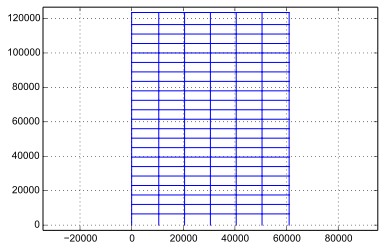

In [9]:
%matplotlib inline
f.plot()

In [10]:
f.doall(pdelta=True,maxiter=40)

iter=1, max D=4863.624801433347, max chg=1623.4931648162215, max % chg=33.380312649482455
iter=2, max D=5697.571804652035, max chg=834.0129403896235, max % chg=14.638041765593137
iter=3, max D=6129.866340595081, max chg=432.32764632436374, max % chg=7.052807064670741
iter=4, max D=6354.974332975217, max chg=225.12492990503688, max % chg=3.5424994360227386
iter=5, max D=6472.517349411434, max chg=117.55174708899995, max % chg=1.8161673541082015
iter=6, max D=6534.009620002818, max chg=61.49679081191243, max % chg=0.9411799857724407
iter=7, max D=6566.224248327125, max chg=32.21697570095694, max % chg=0.4906468996876682
iter=8, max D=6583.119588664347, max chg=16.896562109688603, max % chg=0.25666497292230955
iter=9, max D=6591.988645733922, max chg=8.869694133427402, max % chg=0.13455263062638195
iter=10, max D=6596.647989532584, max chg=4.65967647913476, max % chg=0.07063703393797323
iter=11, max D=6599.097413560883, max chg=2.4495979796784013, max % chg=0.037120197296141966
iter=12, m

In [11]:
f.saveStructuralData('l{}x{}pd'.format(NS,NB),mkdir=True)